In [1]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500'
ADVERSARY_PATH = 'Models\Adversary\default_adversary_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_default_rwd_480'
DATASET_NAME = 'citylearn_challenge_2022_phase_2' #only action is electrical storage

In [2]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from art.attacks.evasion import AutoConjugateGradient as ACG

import pandas as pd
import numpy as np
import os

import KBMproject.utilities as utils

%matplotlib inline

In [3]:
schema = DataSet.get_schema(DATASET_NAME)

Define RL agent

In [4]:
agent = PPO.load(path=f"{AGENT_NAME}")
print('Model loaded from storage')

Model loaded from storage


In [5]:
adv_path = os.path.join(os.getcwd(), '..',ADVERSARY_PATH) #get adversary from parent directory
adv_path = os.path.normpath(adv_path) #resolve '..'
adversary = PPO.load(path=adv_path)
print('Model loaded from storage')

Model loaded from storage


In [6]:
bins = agent.action_space[0].n
env = utils.make_discrete_env(schema=schema,  
                        action_bins=bins,
                        seed=42)

### compare optimal and optimal adversary logits

define victim/ adversarial policies, which are used to generate logits:

In [7]:
from art.estimators.classification import PyTorchClassifier as classifier
from torch.nn import CrossEntropyLoss

victim_policy = classifier(
                            model=utils.extract_actor(agent),
                            loss=CrossEntropyLoss(), 
                            nb_classes=env.action_space[0].n,
                            input_shape=agent.observation_space.shape,
                            device_type='gpu'
                            )

adversary_policy = classifier(
                            model=utils.extract_actor(adversary),
                            loss=CrossEntropyLoss(), 
                            nb_classes=env.action_space[0].n,
                            input_shape=agent.observation_space.shape,
                            device_type='gpu'
                            )

Collect agent/adversary logits/actions for the victim's trajectory (use victim's action)

In [9]:
obs_list = []
victim_a_list = []
adv_a_list = []
victim_logit_list = []
adv_logit_list =[]

observations = env.reset()

while not env.done:
    obs_list.append(observations)
    v_logits = victim_policy.predict(observations, training_mode=False)
    adv_logits = adversary_policy.predict(observations, training_mode=False)
    victim_logit_list.append(v_logits)
    adv_logit_list.append(adv_logits)
    #adv_a = np.argmax(adv_logits) #probably faster to do this as a vectorized operation
    v_a = np.argmax(v_logits)
    victim_a_list.append(v_a)
    #adv_a_list.append(adv_a)
    observations, _, _, _ = env.step(np.array([v_a])) #victim trajectory

In [10]:
df_baseline_obs = pd.DataFrame(obs_list, columns=env.observation_names[0])
#df_baseline_obs.to_csv('baseline_obs.csv')

In [11]:
adv_a = np.squeeze(np.argmax(np.array(adv_logit_list), axis=1)) #take the argmax of each row

Knowing that the action is the index of the largetst logit (where the logits for each sample are a row), the slices below gives us the victim's logit for the optimal and optimal adversarial actions

In [12]:
adv_a_logits = np.squeeze(np.array(victim_logit_list))[np.arange(len(adv_a)), adv_a]

In [13]:
victim_a_logits = np.squeeze(np.array(victim_logit_list))[np.arange(len(victim_a_list)), victim_a_list]

In [14]:
logit_distance = pd.Series(victim_a_logits - adv_a_logits)

In [15]:
logit_distance.describe()

count    8759.000000
mean       21.904232
std         5.920007
min         0.000000
25%        17.761548
50%        21.724623
75%        25.826498
max        44.506714
dtype: float64

<Axes: >

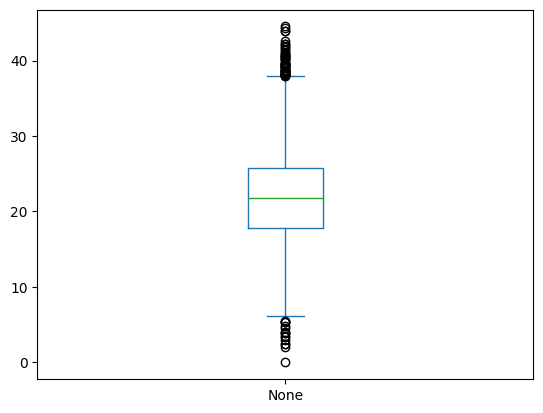

In [16]:
logit_distance.plot.box()

<Axes: ylabel='Density'>

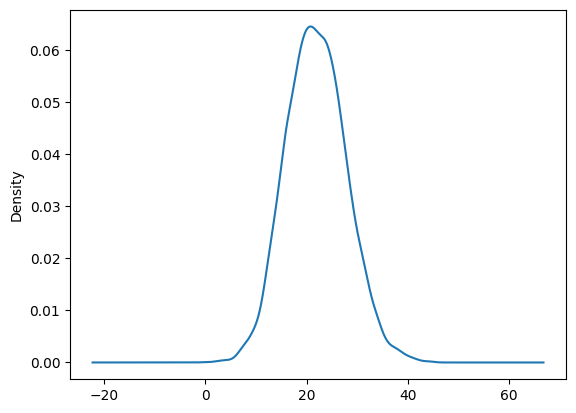

In [17]:
logit_distance.plot.kde()

The untargeted attack using DLR pushes the victim towards the second largest logit/most likely class

In [18]:
victim_2nd_logit =  np.sort(np.squeeze(np.array(victim_logit_list)), axis=1)[:, -2]

In [19]:
second_logit_distance = pd.Series(victim_a_logits - victim_2nd_logit)

In [20]:
second_logit_distance.describe()

count    8759.000000
mean        2.526909
std         2.194312
min         0.000023
25%         0.871967
50%         1.942386
75%         3.562699
max        17.197521
dtype: float64

In [21]:
(logit_distance/second_logit_distance).describe()

count    8.759000e+03
mean     2.301142e+02
std      1.317202e+04
min      0.000000e+00
25%      5.852639e+00
50%      1.115291e+01
75%      2.442857e+01
max      1.223508e+06
dtype: float64

##### Using the logits predicted from the clean and perturbed observations during the untargeted attack, we can learn the logit distance between the learned and adversarial actions

Collect the victim's logits for the untargeted adversarial attack, note that the clean observations are still the result of preceeding adversarial examples, dintinguishing them from the baseline obaservations and trace

In [8]:
perturbed_adv_obs =  pd.read_csv('adv_perturbed_obs.csv', index_col=0, dtype='float32')  #NB pytorch needs float32, float64 raises an error
clean_adv_obs =  pd.read_csv('adv_obs.csv', index_col=0, dtype='float32', nrows=perturbed_adv_obs.shape[0]) #there is an extra entry for the clean observations, no action was taken for it

In [9]:
clean_adv_logit = clean_adv_obs.apply(victim_policy.predict, 
                                      axis='columns',
                                      training_mode=False,)

convert series of 2d arrays to df:

In [10]:
clean_adv_logit = clean_adv_logit.map(np.squeeze).apply(pd.Series) 

In [11]:
clean_adv_logit['max_logit'] =  clean_adv_logit.max(axis='columns')

In [12]:
perturbed_adv_logit = perturbed_adv_obs.apply(victim_policy.predict, 
                                      axis='columns',
                                      training_mode=False,)
perturbed_adv_logit = perturbed_adv_logit.map(np.squeeze).apply(pd.Series)

In [13]:
perturbed_adv_logit['action'] = perturbed_adv_logit.idxmax(axis='columns') #position of largest logit

The clean obs have one more entry (last entry) than the perturb obs, so we can drop it since no action was taken based on it

We want the logit value for the adversarial actions (selected after this observation was perturbed), so we convert everything to np.arrays so we can provide a set of row/col pairs (converted to np arrays)

In [14]:
clean_adv_logit['adv_logit'] = clean_adv_logit.values[perturbed_adv_logit['action'].index.values.astype(int), perturbed_adv_logit['action'].values]

Here is the difference between the logit of learned optimal action, and the adversarial action, using prdictions from the clean observations in the adversarial scenario

In [15]:
clean_adv_logit['max_adv_logit_difference'] =  clean_adv_logit['max_logit'] - clean_adv_logit['adv_logit']

In [16]:
clean_adv_logit['max_adv_logit_difference'].describe()

count    8759.000000
mean        2.644244
std         2.421880
min         0.000000
25%         0.812760
50%         1.962355
75%         3.800384
max        19.762749
Name: max_adv_logit_difference, dtype: float64

<Axes: ylabel='Density'>

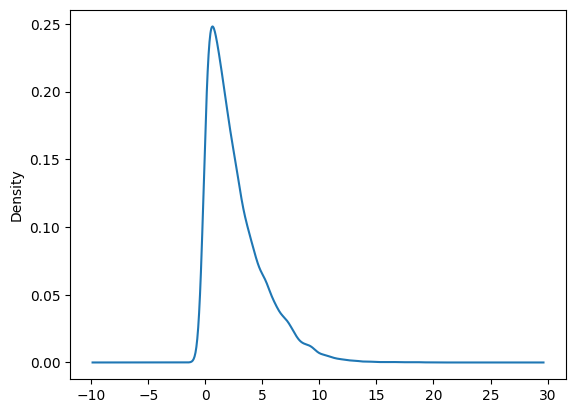

In [17]:
clean_adv_logit['max_adv_logit_difference'].plot.kde()

<Axes: >

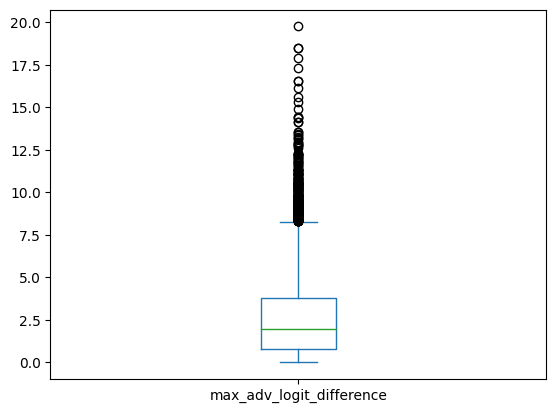

In [18]:
clean_adv_logit['max_adv_logit_difference'].plot.box()